In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-used-cars-dataset/used_cars_data.csv


In [2]:
%%time
# Subset of 200000 rows
df_full = pd.read_csv('/kaggle/input/us-used-cars-dataset/used_cars_data.csv', nrows=200000)

<string>:2: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 8.25 s, sys: 1.18 s, total: 9.43 s
Wall time: 16.2 s


In [3]:
# Count nulls in each column
pd.set_option('display.max_rows', None)
pd.DataFrame(df_full.isna().sum().sort_values(ascending=False))

,0
vehicle_damage_category,200000
combine_fuel_economy,200000
is_certified,200000
bed,198795
cabin,196628
is_oemcpo,188045
is_cpo,182756
bed_height,179748
bed_length,179748
owner_count,93520


In [4]:
%%time
columns_with_too_many_nulls = ['bed_height', 'bed_length', 'is_certified',
                               'combine_fuel_economy', 'vehicle_damage_category']
columns_hard_to_process = ['vin', 'description', 'main_picture_url', 'trimId', 'wheel_system_display',
                           'listing_id', 'trim_name', 'latitude', 'longitude']

df_full_processed = df_full.drop(columns=columns_with_too_many_nulls + columns_hard_to_process)

# Retrieve numbers from column "power"
a = df_full_processed.power.str.replace(",", "").str.split().str[0:4:3]
a = pd.DataFrame([[np.nan, np.nan] if type(i).__name__ != "list" else np.asarray(i).astype("float") for i in a],
                 columns=["horsepower", "horsepower_rpm"])
df_full_processed[["horsepower", "horsepower_rpm"]] = a

# Retrieve numbers from column "torque"
a = df_full_processed.torque.str.replace(",", "").str.split().str[0:4:3]
a = pd.DataFrame([[np.nan, np.nan] if type(i).__name__ != "list" else np.asarray(i).astype("float") for i in a], 
                 columns=["torque", "torque_rpm"])
df_full_processed[["torque", "torque_rpm"]] = a

del a
df_full_processed = df_full_processed.drop(columns=['power'])

# Retrieve numbers from other columns
columns_to_transform = ["back_legroom", "wheelbase", "width", "length", "height", 
                       "fuel_tank_volume", "front_legroom", "maximum_seating"]
extract_num_func = lambda series: series.str.split().str[0].astype(np.float)

df_full_processed[columns_to_transform] = df_full_processed[columns_to_transform].replace({",": "", 
                                                                       "--": np.nan}).apply(extract_num_func)

CPU times: user 10.9 s, sys: 1.15 s, total: 12.1 s
Wall time: 12.1 s


In [5]:
df_train, df_test = train_test_split(df_full_processed, test_size=0.25, random_state=1, shuffle=True)
df_train = df_train.copy()
df_test = df_test.copy()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 76034 to 128037
Data columns (total 53 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   back_legroom          137719 non-null  float64
 1   bed                   879 non-null     object 
 2   body_type             149432 non-null  object 
 3   cabin                 2499 non-null    object 
 4   city                  150000 non-null  object 
 5   city_fuel_economy     126307 non-null  float64
 6   daysonmarket          150000 non-null  int64  
 7   dealer_zip            150000 non-null  object 
 8   engine_cylinders      145584 non-null  object 
 9   engine_displacement   142390 non-null  float64
 10  engine_type           145584 non-null  object 
 11  exterior_color        149999 non-null  object 
 12  fleet                 83495 non-null   object 
 13  frame_damaged         83495 non-null   object 
 14  franchise_dealer      150000 non-null  bool   
 

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
back_legroom,137719.0,37.745934,2.983556,0.0,36.000000,38.100000,39.500000,49.0
city_fuel_economy,126307.0,22.414078,8.559169,7.0,18.000000,21.000000,25.000000,127.0
daysonmarket,150000.0,79.187753,113.653374,0.0,14.000000,36.000000,83.000000,2624.0
engine_displacement,142390.0,2845.667533,1213.582260,700.0,2000.000000,2500.000000,3500.000000,8400.0
front_legroom,141773.0,42.109425,1.564176,0.0,41.000000,41.800000,43.000000,67.0
fuel_tank_volume,142823.0,18.329744,4.893011,1.9,14.800000,17.400000,20.500000,63.5
height,142877.0,65.471671,7.417924,44.3,58.100000,66.100000,69.400000,117.6
highway_fuel_economy,126307.0,29.160553,7.503622,11.0,25.000000,28.000000,32.000000,127.0
horsepower,128836.0,248.449882,87.863223,70.0,177.000000,245.000000,300.000000,808.0
length,142877.0,191.426125,17.963545,106.1,181.500000,188.800000,196.600000,290.0


<AxesSubplot:ylabel='Frequency'>

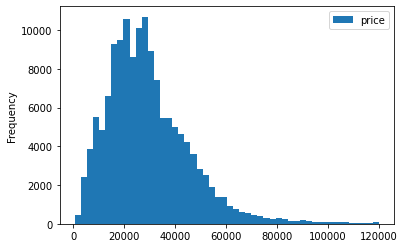

In [8]:
df_train_processed = df_train[(df_train.price < 120000) & (df_train.mileage < 1e6)].copy()
df_train_processed[['price']].plot.hist(bins=50)

<AxesSubplot:xlabel='year', ylabel='owner_count'>

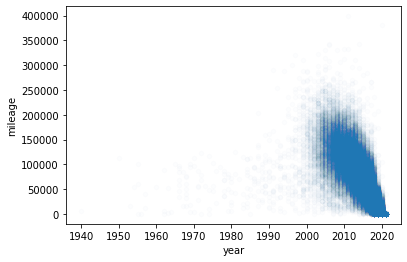

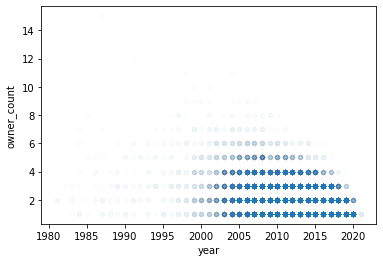

In [9]:
df_train_processed.plot.scatter(x='year', y='mileage', alpha=0.01)
df_train_processed.plot.scatter(x='year', y='owner_count', alpha=0.01)

In [10]:
# Encode 'model_name'
auxiliary_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', 
                                  unknown_value=-1).fit(df_train_processed[['model_name']])
df_train_processed['model_name'] = auxiliary_encoder.transform(df_train_processed[['model_name']])
df_test['model_name'] = auxiliary_encoder.transform(df_test[['model_name']])

In [11]:
# Filling null values in 'mileage' by predicting from 'year'
for col in ['mileage']:
    df_tmp = df_train_processed[df_train_processed[col].isna() == False]
    auxiliary_reg = RandomForestRegressor(n_estimators=50, random_state=1, 
                                          n_jobs=-1).fit(df_tmp[['year']], df_tmp[col])
    preds = auxiliary_reg.predict(df_train_processed[['year']])
    df_train_processed[col] = df_train_processed[col].where(df_train_processed[col].isna() == False, preds)

    preds = auxiliary_reg.predict(df_test[['year']])
    df_test[col] = df_test[col].where(df_test[col].isna() == False, preds)

In [12]:
%%time
# Filling null values
for col in ['seller_rating', 'owner_count']:
    #val = df_train_processed[col].mean()
    val = -1
    df_train_processed[col].fillna(val, inplace = True)
    df_test[col].fillna(val, inplace = True)

fill_na_colnames = ['torque_rpm', 'horsepower_rpm', 'width', 'wheelbase', 'torque',  
                   'maximum_seating', 'length', 'horsepower', 'highway_fuel_economy',
                   'height', 'fuel_tank_volume', 'front_legroom', 'engine_displacement', 'city_fuel_economy',
                   'back_legroom']

# Filling null values by predicting from 'model_name'
for col in fill_na_colnames:
    df_tmp = df_train_processed[df_train_processed[col].isna() == False]
    auxiliary_reg = RandomForestRegressor(n_estimators=50, random_state=1, 
                                          n_jobs=-1).fit(df_tmp[['model_name']], df_tmp[col])
    preds = auxiliary_reg.predict(df_train_processed[['model_name']])
    df_train_processed[col] = df_train_processed[col].where(df_train_processed[col].isna() == False, preds)

    preds = auxiliary_reg.predict(df_test[['model_name']])
    df_test[col] = df_test[col].where(df_test[col].isna() == False, preds)

CPU times: user 2min 10s, sys: 494 ms, total: 2min 10s
Wall time: 37.7 s


In [13]:
%%time
# Encoding categorical variables
# rejected columns: 'listed_date', 'major_options'
no_na_colnames = ['daysonmarket', 'savings_amount', 'year', 'mileage', 
                  'owner_count', 'seller_rating', 'model_name']
category_colnames = ['city', 'exterior_color', 'interior_color', 'make_name',
                     'sp_name', 'transmission_display', 'is_cpo', 'is_oemcpo', 'bed',
                    'body_type', 'engine_cylinders', 'engine_type', 'fleet', 'cabin',
                   'frame_damaged', 'franchise_dealer', 'franchise_make', 'fuel_type', 'has_accidents', 
                   'isCab', 'is_new', 'listing_color',
                   'salvage', 'theft_title', 'transmission', 'wheel_system']
for col in category_colnames:
    df_train_processed[col] = df_train_processed[col].astype(str) 
    df_test[col] = df_test[col].astype(str) 
    df_train_processed[col].fillna('unknown', inplace = True)
    df_test[col].fillna('unknown', inplace = True)
    auxiliary_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', 
                                  unknown_value=-1).fit(df_train_processed[[col]])
    df_train_processed[col] = auxiliary_encoder.transform(df_train_processed[[col]])
    df_test[col] = auxiliary_encoder.transform(df_test[[col]])

CPU times: user 6.28 s, sys: 246 ms, total: 6.53 s
Wall time: 6.53 s


In [14]:
%%time
# Select most important features
all_feature_columns = category_colnames + fill_na_colnames + no_na_colnames
rf_reg = RandomForestRegressor(n_estimators=50, random_state=1, 
                               n_jobs=-1).fit(df_train_processed[all_feature_columns], df_train_processed['price'])
importances = rf_reg.feature_importances_
forest_importances = pd.Series(importances, index=all_feature_columns)
print(forest_importances.sort_values(ascending=False))

mileage                 0.327210
torque                  0.290080
horsepower              0.100661
year                    0.059023
torque_rpm              0.020441
back_legroom            0.015850
length                  0.015181
wheelbase               0.010827
fuel_tank_volume        0.010413
width                   0.010300
wheel_system            0.010200
engine_displacement     0.010058
body_type               0.009098
height                  0.008438
make_name               0.008391
highway_fuel_economy    0.007569
front_legroom           0.007330
city_fuel_economy       0.007164
model_name              0.006252
daysonmarket            0.006086
horsepower_rpm          0.005641
maximum_seating         0.005592
sp_name                 0.004911
seller_rating           0.004757
franchise_make          0.004667
is_new                  0.004318
city                    0.003997
savings_amount          0.003634
interior_color          0.003514
engine_cylinders        0.003374
owner_coun

In [15]:
for col in ['mileage', 'torque', 'horsepower', 'year']:
    scaler = StandardScaler().fit(df_train_processed[[col]])
    df_train_processed[col+'_scale'] = scaler.transform(df_train_processed[[col]])
    df_test[col+'_scale'] = scaler.transform(df_test[[col]])

In [16]:
%%time
# Select hyperparameters by grid search
knn_reg = KNeighborsRegressor(n_jobs=-1)


param_grid = {
    'n_neighbors': [x for x in range(2, 25, 1)]
}

cv_rfc = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv=4, n_jobs=-1)
cv_rfc.fit(df_train_processed[['mileage_scale', 'torque_scale', 'horsepower_scale', 'year_scale']], df_train_processed['price'])
print(cv_rfc.best_params_)
print(cv_rfc.best_score_)

{'n_neighbors': 7}
0.8971854362725515
CPU times: user 1.32 s, sys: 262 ms, total: 1.58 s
Wall time: 49.6 s


In [17]:
%%time
knn_reg = KNeighborsRegressor(n_jobs=-1, n_neighbors=7).fit(df_train_processed[['mileage_scale', 'torque_scale', 
                                                                                'horsepower_scale', 'year_scale']], 
                                                             df_train_processed['price'])
df_train_processed['price_pred'] = knn_reg.predict(df_train_processed[['mileage_scale', 'torque_scale', 'horsepower_scale', 'year_scale']])
df_test['price_pred'] = knn_reg.predict(df_test[['mileage_scale', 'torque_scale', 'horsepower_scale', 'year_scale']])
df_train_processed['error'] = df_train_processed['price'] - df_train_processed['price_pred']

CPU times: user 9.17 s, sys: 33.1 ms, total: 9.21 s
Wall time: 2.89 s


<AxesSubplot:xlabel='price_pred', ylabel='error'>

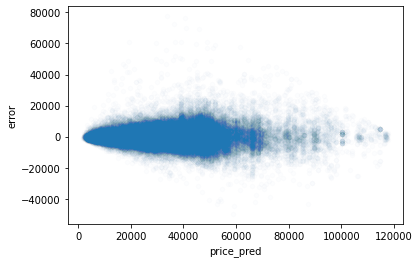

In [18]:
df_train_processed.plot.scatter(x='price_pred', y='error', alpha=0.01)

In [19]:
# Create set of distinct options in 'major_options' feature
df_train_processed['major_options'] = df_train_processed['major_options'].astype(str)
df_test['major_options'] = df_test['major_options'].astype(str) 
options_list = list(df_train_processed['major_options'])
options_set = set()
for opt in options_list:
    for i in opt.split("\'"):
        options_set.add(i)
            
options_set.remove(', ')
options_set.remove('[')
options_set.remove(']')

In [20]:
# Find most correlated options with target
options_corr_list = []
for i in options_set:
    df_train_processed['tmp'] = df_train_processed['major_options'].apply(lambda s: 1 if i in s else 0)
    cor = df_train_processed['tmp'].corr(df_train_processed['error'])
    options_corr_list.append((cor, i))
options_corr_list.sort(reverse=True)
print(options_corr_list[:20])

[(0.18372024997358405, 'Navigation System'), (0.17782258438320236, 'Sunroof/Moonroof'), (0.1326415501685584, 'Leather Seats'), (0.12487118092749917, 'Heated Seats'), (0.09388524284899695, 'Blind Spot Monitoring'), (0.08475111915381399, 'Adaptive Cruise Control'), (0.07596388930375335, 'Lariat Package'), (0.07222076522219636, '502A Luxury Equipment Group'), (0.060985025613296016, 'Premium Package'), (0.06051233483260564, 'Technology Package'), (0.06029326556811275, 'Ultimate Package'), (0.05920617532324169, 'Utility Package'), (0.0551279747300232, 'Remote Start'), (0.053702711453746756, 'Adaptive Suspension'), (0.05173740590398001, 'Sport Chrono Package'), (0.05152218700773073, '802A Luxury Equipment Group'), (0.04759515962524446, 'Off Road Package'), (0.04647374986874545, '5th Wheel'), (0.04444332187958728, 'Parking Sensors'), (0.043329560200386794, 'Tow Package')]


In [21]:
# Add new features to dataframe
new_features_from_major_options = []

for cor, opt in options_corr_list[:20]:
    new_features_from_major_options.append(opt)
    df_train_processed[opt] = df_train_processed['major_options'].apply(lambda s: 1 if opt in s else 0)
    df_test[opt] = df_test['major_options'].apply(lambda s: 1 if opt in s else 0)

In [22]:
%%time
# Encode 'dealer_zip' and 'model_name' by mean target value
#mean_error = df_train_processed['error'].mean()
mean_error = 0
for col in ['dealer_zip', 'model_name']:
    mean_error_dict = dict(df_train_processed.groupby([col])['error'].mean())
    count_dict = dict(df_train_processed.groupby([col])['error'].count())
    lst1 = list(df_train_processed[col].unique())
    lst2 = list(df_test[col].unique())
    lst3 = [x for x in lst2 if x not in lst1]
    mapping = dict()
    for k, v in mean_error_dict.items():
        if count_dict[k] >= 10:
            mapping[k] = v
        else:
            lst3.append(k)
            
    df_train_processed[col] = df_train_processed[col].replace(mapping)
    df_train_processed[col] = df_train_processed[col].replace(lst3, mean_error)
    df_test[col] = df_test[col].replace(mapping)
    df_test[col] = df_test[col].replace(lst3, mean_error)

CPU times: user 1min 36s, sys: 226 ms, total: 1min 36s
Wall time: 1min 36s


In [23]:
print(len(list(df_train_processed['model_name'].unique())))
print(len(list(df_train_processed['dealer_zip'].unique())))

524
755


In [24]:
%%time
# Find most important categories in columns
search_columns_list = category_colnames
categories_corr_list = []
for col in search_columns_list:
    categories = list(df_train_processed[col].unique())
    for cat in categories: 
        val1 = abs(df_train_processed[df_train_processed[col] == cat]['error'].median())
        val2 = abs(df_train_processed[df_train_processed[col] == cat]['error'].mean())
        val3 = df_train_processed[df_train_processed[col] == cat]['error'].count()
        if val3 >= 20:
            categories_corr_list.append((val1, val2, val3, col, cat))
categories_corr_list.sort(reverse=True)
print(categories_corr_list[:80])

[(15341.214285714286, 16002.222943722943, 66, 'make_name', 53.0), (14848.714285714283, 13694.808441558444, 44, 'interior_color', 800.0), (13205.428571428565, 14133.365714285716, 25, 'sp_name', 2046.0), (12849.571428571428, 12414.63305322129, 51, 'make_name', 5.0), (12444.571428571435, 15639.912442396317, 31, 'sp_name', 2823.0), (10233.071428571428, 11645.521428571428, 20, 'exterior_color', 2393.0), (9393.0, 8998.957142857142, 30, 'sp_name', 3017.0), (8584.0, 10922.689440993789, 23, 'sp_name', 3508.0), (8358.428571428572, 8682.100000000002, 20, 'exterior_color', 3687.0), (8185.285714285716, 10193.287442396315, 496, 'make_name', 44.0), (8109.714285714283, 8459.455357142855, 32, 'interior_color', 1039.0), (7961.142857142859, 7184.189189189187, 37, 'city', 379.0), (7889.142857142859, 9622.08860759494, 79, 'sp_name', 3425.0), (7889.142857142859, 9622.08860759494, 79, 'city', 1306.0), (7656.714285714283, 6315.722371967656, 53, 'exterior_color', 95.0), (7172.857142857145, 6610.432653061224, 3

In [25]:
# Add new features to dataframe
new_features_from_important_categories = []

for val1, val2, val3, col, cat in categories_corr_list[:100]:
    new_col = col + '_' + str(cat)
    new_features_from_important_categories.append(new_col)
    df_train_processed[new_col] = df_train_processed[col].apply(lambda s: 1 if s == cat else 0)
    df_test[new_col] = df_test[col].apply(lambda s: 1 if s == cat else 0)

In [26]:
# Model evaluation function
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

def model_evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs(y_true - y_pred) / y_true)*100
    return r2, mae, mape

all_feature_columns = fill_na_colnames + no_na_colnames + \
                      new_features_from_major_options + new_features_from_important_categories + \
                      ['dealer_zip', 'price_pred']

In [27]:
%%time
# Select most important features
rf_reg = RandomForestRegressor(n_estimators=50, random_state=1, 
                               n_jobs=-1).fit(df_train_processed[all_feature_columns], df_train_processed['error'])
importances = rf_reg.feature_importances_
forest_importances = pd.Series(importances, index=all_feature_columns).sort_values(ascending=False)
print(forest_importances[:50])

model_name                     0.140769
price_pred                     0.129530
dealer_zip                     0.090921
daysonmarket                   0.053094
mileage                        0.052861
seller_rating                  0.040561
savings_amount                 0.036482
height                         0.036241
back_legroom                   0.030720
year                           0.026513
length                         0.023328
Navigation System              0.022122
city_fuel_economy              0.021680
highway_fuel_economy           0.021650
Sunroof/Moonroof               0.020646
horsepower                     0.019642
fuel_tank_volume               0.019563
engine_displacement            0.019415
wheelbase                      0.018696
width                          0.017783
torque_rpm                     0.017662
torque                         0.017413
horsepower_rpm                 0.016210
front_legroom                  0.014879
maximum_seating                0.012644


In [28]:
new_feature_columns = list(forest_importances[forest_importances > 0.0002].index)
print(new_feature_columns)

['model_name', 'price_pred', 'dealer_zip', 'daysonmarket', 'mileage', 'seller_rating', 'savings_amount', 'height', 'back_legroom', 'year', 'length', 'Navigation System', 'city_fuel_economy', 'highway_fuel_economy', 'Sunroof/Moonroof', 'horsepower', 'fuel_tank_volume', 'engine_displacement', 'wheelbase', 'width', 'torque_rpm', 'torque', 'horsepower_rpm', 'front_legroom', 'maximum_seating', 'Leather Seats', 'Heated Seats', 'Adaptive Cruise Control', 'owner_count', 'Blind Spot Monitoring', 'Remote Start', 'Parking Sensors', 'Premium Package', 'wheel_system_1.0', 'Technology Package', 'Tow Package', 'Adaptive Suspension', 'Lariat Package', 'Off Road Package', 'interior_color_800.0', 'Utility Package', '5th Wheel', 'engine_type_13.0', 'engine_cylinders_13.0', 'make_name_5.0', 'Ultimate Package', '502A Luxury Equipment Group', 'make_name_44.0', 'engine_type_16.0', 'engine_cylinders_16.0', 'interior_color_1039.0', 'franchise_make_33.0', 'sp_name_2487.0', 'interior_color_3567.0', 'sp_name_1217

In [ ]:
%%time
# Select RF hyperparameters by grid search
rf_reg = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=-1)

param_grid = {
    #'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [x for x in range(2, 11, 1)]
}

cv_rfc = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=4, n_jobs=-1)
cv_rfc.fit(df_train_processed[new_feature_columns], df_train_processed['error'])
print(cv_rfc.best_params_)
print(cv_rfc.best_score_)

In [30]:
%%time
# Validate list of features
feature_columns = new_feature_columns[:]
df1, df2 = train_test_split(df_train_processed, test_size=0.25, random_state=1, shuffle=True)
df1 = df1.copy()
df2 = df2.copy()
rf_reg = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=-1,
                              max_features='sqrt', min_samples_leaf=1).fit(df1[feature_columns], df1['error'])
y_preds = rf_reg.predict(df2[feature_columns]) + df2['price_pred']

r2, mae, mape = model_evaluate(df2['price'], y_preds)
for col in new_feature_columns:
    print(col)
    features_tmp = feature_columns[:]
    features_tmp.remove(col)
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=1, n_jobs=-1,
                                  max_features='sqrt', min_samples_leaf=1).fit(df1[features_tmp], df1['error'])
    y_preds = rf_reg.predict(df2[features_tmp]) + df2['price_pred']

    r2_, mae_, mape_ = model_evaluate(df2['price'], y_preds)
    if mae_ < mae:
        feature_columns = features_tmp
        mae = mae_    

model_name
price_pred
dealer_zip
daysonmarket
mileage
seller_rating
savings_amount
height
back_legroom
year
length
Navigation System
city_fuel_economy
highway_fuel_economy
Sunroof/Moonroof
horsepower
fuel_tank_volume
engine_displacement
wheelbase
width
torque_rpm
torque
horsepower_rpm
front_legroom
maximum_seating
Leather Seats
Heated Seats
Adaptive Cruise Control
owner_count
Blind Spot Monitoring
Remote Start
Parking Sensors
Premium Package
wheel_system_1.0
Technology Package
Tow Package
Adaptive Suspension
Lariat Package
Off Road Package
interior_color_800.0
Utility Package
5th Wheel
engine_type_13.0
engine_cylinders_13.0
make_name_5.0
Ultimate Package
502A Luxury Equipment Group
make_name_44.0
engine_type_16.0
engine_cylinders_16.0
interior_color_1039.0
franchise_make_33.0
sp_name_2487.0
interior_color_3567.0
sp_name_1217.0
interior_color_3628.0
sp_name_1653.0
CPU times: user 26min 11s, sys: 7.03 s, total: 26min 18s
Wall time: 7min 1s


In [31]:
print(feature_columns)

['model_name', 'price_pred', 'dealer_zip', 'seller_rating', 'savings_amount', 'height', 'back_legroom', 'year', 'length', 'Navigation System', 'city_fuel_economy', 'highway_fuel_economy', 'Sunroof/Moonroof', 'horsepower', 'fuel_tank_volume', 'engine_displacement', 'wheelbase', 'width', 'torque_rpm', 'torque', 'horsepower_rpm', 'front_legroom', 'maximum_seating', 'Leather Seats', 'Heated Seats', 'Adaptive Cruise Control', 'owner_count', 'Blind Spot Monitoring', 'Remote Start', 'Parking Sensors', 'Premium Package', 'wheel_system_1.0', 'Technology Package', 'Tow Package', 'Adaptive Suspension', 'Lariat Package', 'Off Road Package', 'interior_color_800.0', 'Utility Package', '5th Wheel', 'engine_type_13.0', 'engine_cylinders_13.0', 'make_name_5.0', 'Ultimate Package', '502A Luxury Equipment Group', 'make_name_44.0', 'engine_type_16.0', 'engine_cylinders_16.0', 'interior_color_1039.0', 'franchise_make_33.0', 'sp_name_2487.0', 'interior_color_3567.0', 'sp_name_1217.0', 'interior_color_3628.0

In [32]:
%%time
# Build final RF model and evaluate metrics
rf_reg = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1,
                              max_features='sqrt', min_samples_leaf=1).fit(df_train_processed[feature_columns], df_train_processed['error'])
y_preds = rf_reg.predict(df_train_processed[feature_columns]) + df_train_processed['price_pred']

r2, mae, mape = model_evaluate(df_train_processed['price'], y_preds)
print("In sample R^2 score: " + str(r2))
print("In sample Mean Absolute Error: " + str(mae))
print("In sample Mean Absolute Percentage Error: " + str(mape))

In sample R^2 score: 0.994952115388563
In sample Mean Absolute Error: 666.3113462296134
In sample Mean Absolute Percentage Error: 2.6895477013379203
CPU times: user 1min 24s, sys: 895 ms, total: 1min 25s
Wall time: 22 s


In [33]:
y_preds = rf_reg.predict(df_test[feature_columns]) + df_test['price_pred']
r2, mae, mape = model_evaluate(df_test['price'], y_preds)
print("Out of sample R^2 score: " + str(r2))
print("Out of sample Mean Absolute Error: " + str(mae))
print("Out of sample Mean Absolute Percentage Error: " + str(mape))

Out of sample R^2 score: 0.6346049758857892
Out of sample Mean Absolute Error: 2371.292958441128
Out of sample Mean Absolute Percentage Error: 7.921386912901594


In [ ]:
%%time
# Define the grid of xgb hyperparameters to search
hyperparameter_grid = {
    'n_estimators': [20],
    'max_depth': [12, 14, 16],
    'learning_rate': [0.25, 0.3, 0.35, 0.4],
    'min_child_weight': [2, 3, 4],
    'booster': ['gbtree'],
    'base_score': [0.35, 0.4, 0.45]
    }

xgb_reg = XGB.XGBRegressor()
cv_rfc = RandomizedSearchCV(estimator=xgb_reg,
            param_distributions=hyperparameter_grid,
            cv=4, n_iter=10, n_jobs=-1,
            random_state=3)
cv_rfc.fit(df_train_processed[feature_columns], df_train_processed['error'])
print(cv_rfc.best_params_)
print(cv_rfc.best_score_)

In [34]:
%%time
# Build final xgb model and evaluate metrics
xgb_reg = XGB.XGBRegressor(base_score=0.4, booster='gbtree', 
       learning_rate=0.25,
       max_depth=14, min_child_weight=3, n_estimators=70,
       n_jobs=-1, random_state=1, seed=42).fit(df_train_processed[feature_columns], 
                                                           df_train_processed['error'])
y_preds = xgb_reg.predict(df_train_processed[feature_columns]) + df_train_processed['price_pred']

r2, mae, mape = model_evaluate(df_train_processed['price'], y_preds)
print("In sample R^2 score: " + str(r2))
print("In sample Mean Absolute Error: " + str(mae))
print("In sample Mean Absolute Percentage Error: " + str(mape))

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In sample R^2 score: 0.9958622782919758
In sample Mean Absolute Error: 672.5869570120778
In sample Mean Absolute Percentage Error: 2.8527677941936522
CPU times: user 2min 20s, sys: 246 ms, total: 2min 21s
Wall time: 37 s


In [35]:
y_preds = xgb_reg.predict(df_test[feature_columns]) + df_test['price_pred']
r2, mae, mape = model_evaluate(df_test['price'], y_preds)
print("Out of sample R^2 score: " + str(r2))
print("Out of sample Mean Absolute Error: " + str(mae))
print("Out of sample Mean Absolute Percentage Error: " + str(mape))

Out of sample R^2 score: 0.6462484972427733
Out of sample Mean Absolute Error: 2236.6607294411197
Out of sample Mean Absolute Percentage Error: 7.40703912128485


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
